## Interactive model tester
This allows interactive use of a saved Estimator model against systems configured for the **formal-test-set**.

In [34]:
from pathlib import Path
import json
import re

import numpy as np
import astropy.units as u
from astropy.time import Time
from lightkurve import LightCurve, FoldedLightCurve

%matplotlib widget 
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

# Support for interactive widgets
from IPython.display import *
from ipywidgets import *

from ebop_maven.libs import lightcurve, deb_example, jktebop
from ebop_maven import datasets
from ebop_maven.estimator import Estimator
import plots, model_testing

### Target selection
These targets are taken from the **formal-test-dataset**. These are accompanied with published parameters which we can use to test our results.

In [35]:
selected_target = "CW Eri"
targets_config_file = Path.cwd() / "config" / "formal-test-dataset.json"
with open(targets_config_file, mode="r", encoding="utf8") as cf:
    targets_cfg = json.load(cf)

target_selection = Dropdown(options=[t for t in targets_cfg], value=selected_target)
display(target_selection)

Dropdown(index=13, options=('V436 Per', 'V539 Ara', 'psi Cen', 'V402 Lac', 'V1229 Tau', 'V889 Aql', 'WW Aur', …

### Download the target assets
Searches for the target in the MAST archive and downloads timeseries fits files. Subsequent calls may be serviced from a local cache.

In [36]:
target = target_selection.get_interact_value()
target_cfg = targets_cfg[target]
sectors = [int(s) for s in target_cfg["sectors"].keys() if s.isdigit()]

# This will download and cache the timeseries fits files
fits_dir = Path.cwd() / "cache" / re.sub(r'[^\w\d-]', '_', target.lower())
lightcurve.find_lightcurves(target, fits_dir, sectors,
                            mission = target_cfg.get("mission", "TESS"),
                            author=target_cfg.get("author", "SPOC"),
                            exptime=target_cfg.get("exptime", None))

Searching for lightcurves based on; target=CW Eri, sectors=[31], mission=TESS, author=SPOC and exptime=None
Looking for previously downloaded fits within /home/steveo/projects/main/ebop_maven/cache/cw_eri
Found 2 existing fits matching mission and author criteria
Found the required 1 fits also meeting the sectors & exptime criteria. Will load the requested lightcurves from these.


LightCurveCollection of 1 objects:
    0: <TessLightCurve LABEL="TIC 98853987" SECTOR=31 AUTHOR=SPOC FLUX_ORIGIN=sap_flux>

### Create our Estimator
Loads the trained machine learning model into an Estimator class. The Estimator makes the model easier to use by handling inputs & outputs, naming features & labels and any scaling of label values.

In [37]:
model_path = Path.cwd() / "drop" / "cnn_ext_model.keras"
estimator = Estimator(model=model_path)

Estimator loading model file '/home/steveo/projects/main/ebop_maven/drop/cnn_ext_model.keras'...
Loaded model 'CNN-Ext-Estimator' last modified at 2024-04-29T13:27:16.302374.
Expects each input dict to hold: mags, phiS, dS_over_dP
	The mags feature to be of 1024 bins length, wrapped after phase 0.75
Each output dict will publish:   rA_plus_rB, k, J, ecosw, esinw, inc, rA_plus_rB_sigma, k_sigma, J_sigma, ecosw_sigma, esinw_sigma, inc_sigma


### Ingest the lightcurves
This will open the lightcurve/timeseries fits files for the target.
For each lightcurve we perform the following initial ingest actions:
- mask out rows where the quality column matches the quality_bitmask from the target's config
- optionally mask out any distorted regions indicated by quality_mask (from, to) time ranges in the target's config
- optionally bin the lightcurve as indicated by any bin_time item in the target's config
- generate delta_mag and delta_mag_err differential magnitude columns
- de-trend the lightcurve by fitting and subtracting a low-order polyomial
- create a phase-folded copy of the lightcurve, about the primary_epoch and period from the target's config

Once we have the phase-folded lightcurves we can fit an interpolated model to it
with the number of bins matching the input requirement of the Estimator's mag feature.
Alongside this we gather any further simple feature values the Estimator will require.

In [38]:
sectors_data = []          # Will hold the LC data to be fitted with JKTEBOP

for sector in sectors:
    sector_cfg = datasets.sector_config_from_target(sector, target_cfg)

    # These are mandatory, so error if missing
    labels = sector_cfg["labels"]
    period = sector_cfg["period"] * u.d
    pe = sector_cfg["primary_epoch"]

    # The basic light-curve data read, rectified & extended with delta_mag and delta_mag_err cols
    lc = datasets.prepare_lc_for_target_sector(target, sector, sector_cfg, fits_dir, verbose=True)

    # Get the phase folded and binned mags feature
    pe = lightcurve.to_lc_time(pe, lc)
    print(f"Creating phase normalized, folded lightcurves about", f"{pe.format} {pe} & {period}.")
    mags_bins = estimator.mags_feature_bins
    wrap_phase = estimator.mags_feature_wrap_phase
    fold_lc = lc.fold(period, pe, wrap_phase=u.Quantity(wrap_phase), normalize_phase=True)
    phases, mags = lightcurve.get_reduced_folded_lc(flc=fold_lc, num_bins=mags_bins, phase_pivot=wrap_phase)
    
    # omega & ecc are not used as labels but we may need them for phiS
    ecosw, esinw = labels["ecosw"], labels["esinw"]
    omega = sector_cfg.get("omega", None) or np.rad2deg(np.arctan(np.divide(esinw, ecosw))) if ecosw else 0
    ecc = sector_cfg.get("ecc", None) or np.divide(ecosw, np.cos(np.deg2rad(omega))) if ecosw else 0

    # This is everything we need for this sector going forward
    sectors_data += [{
        "sector": sector,
        "file_stem": f"{re.sub(r'[^\w\d-]', '-', target.lower())}-{sector:03d}",
        "config": sector_cfg,
        "labels": labels,
        "pe": pe,
        "period": period,

        # For plots and JKTEBOP dat file
        "lc": lc,
        "fold_lc": fold_lc,
        "phases": phases,

        # Inputs for ML parameter estimatation
        "mags": mags,
        "phiS": lightcurve.expected_secondary_phase(labels["ecosw"], ecc),
        "dS_over_dP": lightcurve.expected_ratio_of_eclipse_duration(labels["esinw"])
    }]

Searching for lightcurves based on; target=CW Eri, sectors=[31], mission=TESS, author=SPOC and exptime=short
Looking for previously downloaded fits within /home/steveo/projects/main/ebop_maven/cache/cw_eri
Found 2 existing fits matching mission and author criteria
Found the required 1 fits also meeting the sectors & exptime criteria. Will load the requested lightcurves from these.
NaN/negative flux masks match 0 row(s).
Time range mask(s) matched a further 0 row(s).
	Generated polynomial; y = poly(x, c0 = -12.432101589922793, c1 = 7.209015883953336e-05, c2 = -9.30984102858426e-06) (sigma(fit_ydata)=5.904455e-04 mag)
Creating phase normalized, folded lightcurves about btjd 2163.057026533 & 2.728420258 d.


### Plot the sector light-curves alongside the phase folded model
For each sector generate a plot of the ingested lightcurve with the position
of the primary epoch highlighted and the phase-folded lightcurve overlaid with
the interpolated mags feature which will be used as an input to the Estimator.

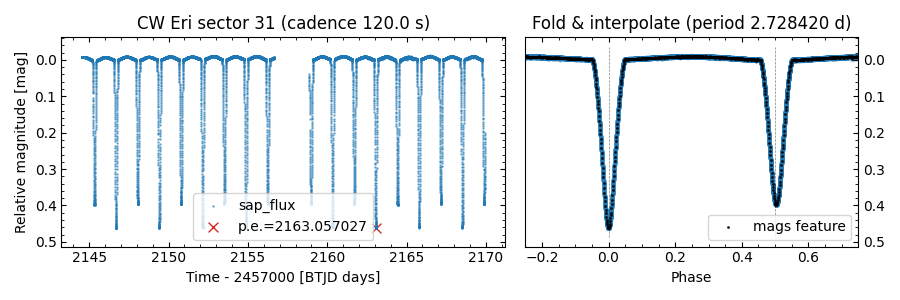

In [39]:
nrows = len(sectors)
fig = plt.figure(figsize=(9, 3*nrows), tight_layout=True)
gs = GridSpec(figure=fig, ncols=2, nrows=nrows, width_ratios=(4, 3))
target_label = target_cfg.get("label", target)
for ix, sd in enumerate(sectors_data):
    exptime = sd["lc"].meta["FRAMETIM"] * sd["lc"].meta["NUM_FRM"] * u.s  
    pe, pe_mag = sd["pe"].value, lc["delta_mag"].max().value

    ax_lc = fig.add_subplot(gs[ix, 0])
    sd["lc"].scatter(ax=ax_lc, column="delta_mag", s=3, alpha=.5,label=sd['lc'].meta['FLUX_ORIGIN'])
    ax_lc.scatter([pe], [pe_mag], marker="x", s=50., lw=1., c="tab:red",
                  label=f"p.e.={sd["pe"].value:.6f}", zorder=-10)
    plots.format_axes(ax_lc, title=f"{target_label} sector {sd['sector']} (cadence {exptime})",
                      ylabel="Relative magnitude [mag]", inverty=True, legend_loc="best")

    ax_fld = fig.add_subplot(gs[ix, 1], sharey=ax_lc)
    sd["fold_lc"].scatter(ax=ax_fld, column="delta_mag", s=20, alpha=.25, label=None)
    ax_fld.scatter(phases, mags, c="k", alpha=.75, marker=".", s=5, lw=1, label="mags feature")
    (ymin, ymax) = ax_fld.get_ylim()
    ax_fld.vlines([0.0, 0.5], ymin, ymax, linestyles="--", color="k", lw=.5, alpha=.5)
    plots.format_axes(ax_fld, title=f"Fold & interpolate (period {period:.6f})", ylabel="",
                      xlim=(min(phases), max(phases)), yticklabel_right=True, legend_loc="best")
plt.show()

### Estimate the JKTEBOP fitting parameters
This is where the magic happens!

For each sector, the Estimator is used to predict the values of the
$r_A+r_B$, $k$, $J$, $e\cos{\omega}$, $e\sin{\omega}$ and $i$
parameters for use as input values of subsequent fitting with JKTEBOP.

If iterations >1 then the MC Dropout algorithm will be used which repeats the
requested predictions the given number of times with Dropout enabled. Dropout
randomly drops a proportion of the neurons in the full neural network, so in
this configuration each iteration will give a predition from a different subset
of the full network. The final output predictions will be the mean and 1-sigma
values calculated from the set of predictions from every iteration.

The table shows the predictions (nominals) against the (published) label values
for each sector and residual, MAE and MSE loss metrics.

In [40]:
# An iterations value over 1 triggers the MC Dropout algorithm giving us nominal and 1-sigma values.
# The model predicts scaled values (e.g. inc*0.01) which the Estimator "unscales" for us.
instance_features = [{ f: sd[f] for f in ["mags", "phiS", "dS_over_dP"] } for sd in sectors_data]
predictions = estimator.predict(instance_features, iterations=1000)

# Copy these into sector data
for (sd, pred) in zip(sectors_data, predictions):
    sd["predictions"] = pred

# Produce some statistics on the quality of the predictions.
rescale = False
print(f"The Estimator's {'' if rescale else 'un'}scaled predictions for {target} by sector\n")
labels = [sd["labels"] for sd in sectors_data]
titles = [f"Sector {sd['sector']:03d}" for sd in sectors_data]
model_testing.table_of_predictions_vs_labels(labels, predictions, estimator, titles, None, rescale)

The Estimator's unscaled predictions for CW Eri by sector

------------------------------------------------------------------------------------------------------
Sector 031   | rA_plus_rB          k          J      ecosw      esinw        inc        MAE        MSE
------------------------------------------------------------------------------------------------------
Label        |   0.306620   0.703700   0.926200   0.005020  -0.012100  86.381000
Prediction   |   0.336425   0.914097   0.919271  -0.005073  -0.005167  85.240593
O-C          |  -0.029805  -0.210397   0.006929   0.010093  -0.006933   1.140407   0.234094   0.224314
MAE          |   0.029805   0.210397   0.006929   0.010093   0.006933   1.140407   0.234094
MSE          |   0.000888   0.044267   0.000048   0.000102   0.000048   1.300528              0.224314


### Perform JKTEBOP fitting on the target's lightcurves
The parameters estimated above and the ingested lightcurves are now used to generate
equivalent pairs of in & dat files for each sector. JKTEBOP is invoked against these
to fit the lightcurves with the EBOP algorithm.

In [41]:
for sd in sectors_data:
    # JKTEBOP won't overwrite files so make sure we clear down anything which could cause trouble
    file_stem = sd["file_stem"]
    for file in jktebop.get_jktebop_dir().glob(f"{file_stem}.*"):
        file.unlink()

    in_filename = jktebop.get_jktebop_dir() / f"{file_stem}.in"
    dat_filename = jktebop.get_jktebop_dir() / f"{file_stem}.dat"

    # published fitting params that may be needed for good fit
    sector_cfg = sd["config"]
    fit_overrides = sector_cfg.get("fit_overrides", {})

    params = {
        **model_testing.base_jktebop_task3_params(
            sd["period"].to(u.d).value, sd["pe"].value, dat_filename.name, file_stem, sector_cfg),
        **sd["predictions"],                    # Now apply the predictions over the default params
        **fit_overrides
    }

    # Add instructions for scale-factor poly fitting and chi^2 adjustment (to 1.0)
    segments = lightcurve.find_lightcurve_segments(sd["lc"], 0.5, return_times=True)
    append_lines = jktebop.build_poly_instructions(segments, "sf", 1) + ["", "chif", ""]

    # Append any light-ratio (lrat) instructions picked up from the config
    if "lrat" in sector_cfg:
        append_lines += [ f"lrat {text}" for text in sector_cfg.get("lrat", []) ]

    jktebop.write_in_file(in_filename, task=3, append_lines=append_lines, **params)
    jktebop.write_light_curve_to_dat_file(sd["lc"], dat_filename,
                                        column_formats=[lambda t: f"{t.value:.6f}", "%.6f", "%.6f"])
    
    # Don't consume the output files so they're available for subsequent plotting
    print(f"Fitting {target} sector {sd['sector']:03d} with JKTEBOP task 3...")
    par_filename = jktebop.get_jktebop_dir() / f"{file_stem}.par"
    list(jktebop.run_jktebop_task(in_filename, par_filename, stdout_to=sys.stdout))

Fitting CW Eri sector 031 with JKTEBOP task 3...
  
JKTEBOP  v44  John Southworth (Keele University, UK, taylorsouthworth~gmail.com)
Task 3  finds the best fit of the model to observations  (formal errorbars only)
>> Read parameters for polynomial  1, to be applied to parameter "sf" over a given time interval
>> Read parameters for polynomial  2, to be applied to parameter "sf" over a given time interval
>> Opened new parameter  file:  cw-eri-031.par                                    
>> Opened new LC output  file:  cw-eri-031.out                                    
>> Opened new model fit  file:  cw-eri-031.fit                                    
>> Read  16671 datapoints (with errors) from file cw-eri-031.dat                                    
>> Read  2 polynomial datasets from the input file
>> Best fit has been found after 54 iterations.
>> Done iteration 1 to adjust errorbars. Chisqred values:   4.521 
>> Done iteration 2 to adjust errorbars. Chisqred values:   1.000 
>> Best f

### Review the JKTEBOP fitting results
For each fitted sector, JKTEBOP produces parameter (par), model (fit) and
fitted lightcurve (out) files. We plot the phase folded lightcurve data
overlaid with the corresponding fitted model for each sector from the out files.

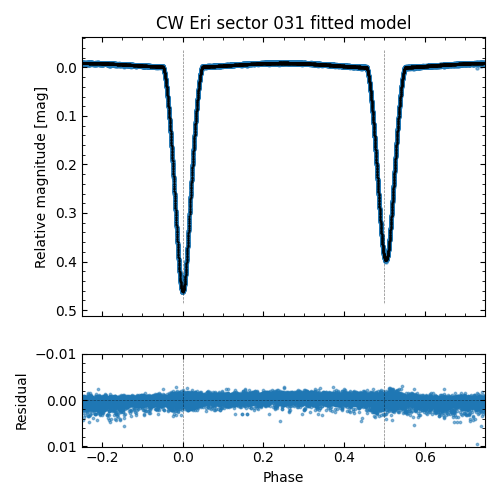

In [42]:
# Sectors arranged 2 columns across, then down a line and so on...
ncols = min(len(sectors_data), 2)
nrows = int(np.ceil(len(sectors_data) / ncols))
fig = plt.figure(figsize=(5*ncols, 5*nrows), tight_layout=True)
out_gs = GridSpec(figure=fig, ncols=ncols, nrows=nrows)

for ix, sd in enumerate(sectors_data):
    with open(jktebop.get_jktebop_dir() /f"{sd['file_stem']}.out", mode="r", encoding="utf8") as ff:
        fit_data =  np.loadtxt(ff, usecols=[3, 4, 5], comments="#", dtype=np.double, unpack=True)
        fit_data[0][fit_data[0] > np.max(sd["fold_lc"].time).value] -= 1.

    # A Nested grid of two stacked Axes. Upper for the folded lc & model and lower for the residuals
    in_gs = GridSpecFromSubplotSpec(ncols=1, nrows=2, height_ratios=[3, 1], subplot_spec=out_gs[ix])
    ax_fld = fig.add_subplot(in_gs[0, 0])
    sd["fold_lc"].scatter(ax=ax_fld, column="delta_mag", s=20, alpha=.5, label=None)
    ax_fld.scatter(fit_data[0], fit_data[1], c="k", alpha=.5, marker=".", s=3, lw=.5, label=None)
    (ymin, ymax) = ax_fld.get_ylim()
    ax_fld.vlines([0.0, 0.5], ymin, ymax, linestyles="--", color="k", lw=.5, alpha=.5)
    ylabel = "Relative magnitude [mag]" if ix % 2 == 0 else ""
    plots.format_axes(ax_fld, xlabel="",ylabel=ylabel, xlim=(min(phases),max(phases)), inverty=True,
                      title=f"{target_cfg.get('label', target)} sector {sector:03d} fitted model")
    plt.setp(ax_fld.get_xticklabels(), visible=False) # Hides xtick labels on this part shared axes

    ax_res = fig.add_subplot(in_gs[1, 0], sharex=ax_fld)
    ax_res.scatter(x=fit_data[0], y=fit_data[2], s=3, alpha=.5)
    abs_max_ylim = max(np.abs(ax_res.get_ylim()))
    plots.format_axes(ax_res, title="", xlabel="Phase", ylabel="Residual",
                      xlim=(min(phases), max(phases)), ylim=(abs_max_ylim, -abs_max_ylim))
    (ymin, ymax) = ax_res.get_ylim()
    ax_res.vlines([0.0, 0.5], ymin, ymax, linestyles="--", color="k", lw=.5, alpha=.5)
    ax_res.hlines([0.0], min(phases), max(phases), linestyles="--", color="k", lw=.5, alpha=.5)
plt.show()

In [43]:
fit_prms = ["rA_plus_rB", "k", "J", "ecosw", "esinw", "inc", "L3", "bP", "ecc", "omega", "rA", "rB"]
jktebop_preds = []
for sd in sectors_data:
    par_filename = jktebop.get_jktebop_dir() / f"{sd['file_stem']}.par"
    fitted_params = jktebop.read_fitted_params_from_par_file(par_filename, fit_prms)
    sd["jktebop_params"] = fitted_params

    print(f"{target} sector {sd['sector']:03d} JKTEBOP fitted parameters")
    for param, (val, err) in fitted_params.items():
        print(f"{param:>10s}: {val:10.6f}", f"+/- {err:.6f}" if err else "")

CW Eri sector 031 JKTEBOP fitted parameters
rA_plus_rB:   0.306758 +/- 0.000124
         k:   0.703879 +/- 0.000806
         J:   0.945782 +/- 0.003801
     ecosw:   0.005132 +/- 0.000005
     esinw:  -0.012137 +/- 0.000466
       inc:  86.355639 +/- 0.022393
        L3:  -0.014114 +/- 0.001242
        bP:   0.357336 
       ecc:   0.013177 
     omega: 292.918608 
        rA:   0.180035 
        rB:   0.126723 


In [44]:
print(f"The JKTEBOP model's parameters vs the label values for {target} by sector\n")
model_testing.table_of_predictions_vs_labels(
    labels=[sd["labels"] for sd in sectors_data],
    predictions=[sd["jktebop_params"] for sd in sectors_data],
    estimator=estimator,
    block_headings=[f"Sector {sd['sector']:03d}" for sd in sectors_data])

The JKTEBOP model's parameters vs the label values for CW Eri by sector

------------------------------------------------------------------------------------------------------
Sector 031   | rA_plus_rB          k          J      ecosw      esinw        inc        MAE        MSE
------------------------------------------------------------------------------------------------------
Label        |   0.306620   0.703700   0.926200   0.005020  -0.012100  86.381000
Prediction   |   0.306758   0.703879   0.945782   0.005132  -0.012137  86.355639
O-C          |  -0.000138  -0.000179  -0.019582  -0.000112   0.000037   0.025361   0.007568   0.000171
MAE          |   0.000138   0.000179   0.019582   0.000112   0.000037   0.025361   0.007568
MSE          |   0.000000   0.000000   0.000383   0.000000   0.000000   0.000643              0.000171
